# Lazyfit Feature Overview

Lazyfit provides a convenient wrapper for the scipy.curve_fit() fitting tool.
It includes several built-in fit models for which parameter guesses and bounds are automatically generated. 

This notebook demonstrates all the functionality of the Lazyfit library for 1-dimensional fitting problems.
See the [model_catalog](https://github.com/M-Hayhurst/LazyFit/blob/main/example_notebooks/model_catalog.ipynb) notebook for a list of fit models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import lazyfit

# Generate some test data

As an example, consider an x,y dataset resembling a Lorentzian distribution plus a constant background.
Fitting a Lorentzian and extracting its position and width is a common problem in spectroscopy.

In [2]:
# test data parameters
A = 500 # amplitude
x0 = 100 # peak position
bg = 50 # constant background
FWHM = 2 # lorentzian full width half maximum

# generate test data
x = np.linspace(x0-10, x0+10, 50)
y = A/(1+(x-x0)**2/(FWHM/2)**2) + bg
y = np.random.poisson(lam=y) # add poissonian noise to data
dy = np.sqrt(y) # retroactively estimate errors

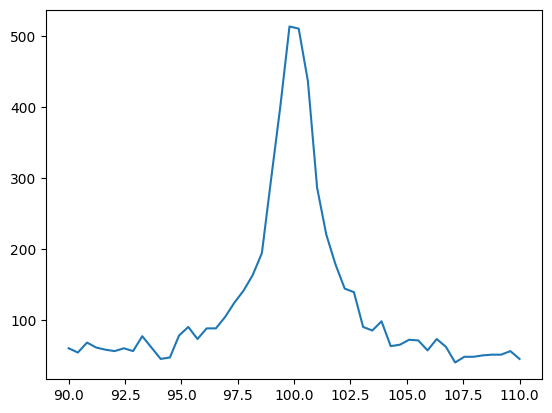

In [3]:
plt.plot(x, y)

# Fully automatic fitting and plotting

As a bare minimum, pass the fit model name together with the x and y data to lazyfit.fit()

In [4]:
fit = lazyfit.fit('lorentz', x, y)

This will return a LazyFitWrapper object. You can immediately plot the fit by running fit.plot(). 

This displays the fit parameters in addition to N DOF, the number of degress of freedom (number of datapoints minus number of fit parameters)

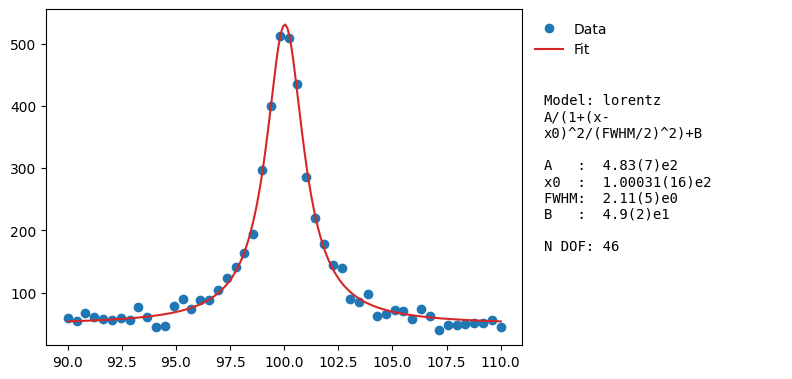

In [5]:
fig = fit.plot() # plots the data and fit and returns a figure handle

## Fitting with errors

lazyfit also takes y-data errors as an optional argument.
You can either pass an array the same length and x and y or a float in the case of constant errors.

In [6]:
fit = lazyfit.fit('lorentz', x, y, dy=dy)

Plotting will then represent data as errorbars and add additional statistics:

chi2 = Chi squared sum

chi2red = Chi squared normalised to number of degrees of freedom

p = Probability of null hypothesis given chisquared sum, and degrees of freedom.

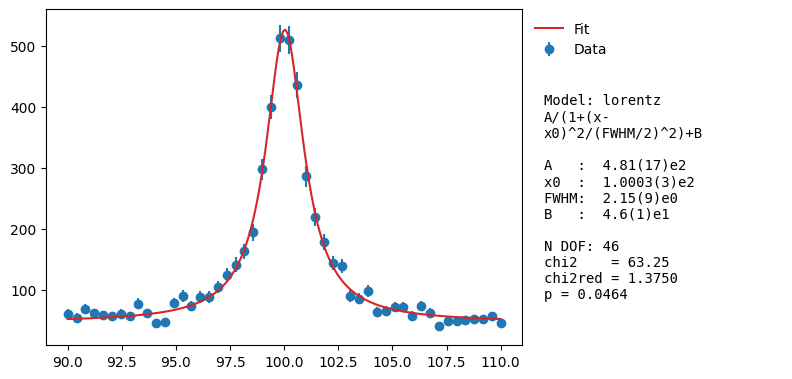

In [7]:
fig = fit.plot() # plots the data and fit and returns a figure handle

## Retrieving fit parameters 

In [8]:
fit.params # get fit parameters in the order they are specified in the fit model

array([481.14060624, 100.02927629,   2.15498015,  46.17410233])

In [9]:
fit.errors # get errors on the fit parameters (this is the square root of the covariance matrix diagonal)

array([17.18576947,  0.03168003,  0.09339344,  1.97926161])

In [10]:
fit.params_dict # get fit paramters as a dictionary

{'A': 481.1406062417004,
 'x0': 100.02927629278736,
 'FWHM': 2.1549801520953036,
 'B': 46.17410233337257}

In [11]:
fit.errors_dict # fit errors as a dictionary

{'A': 17.18576947207241,
 'x0': 0.031680028346781595,
 'FWHM': 0.09339344291394375,
 'B': 1.9792616142102677}

In [12]:
fit.COVB # covarience matrix, same ordering as in fit.params

array([[ 2.95350672e+02, -6.56425140e-04, -1.14379181e+00,
         4.22888902e+00],
       [-6.56425140e-04,  1.00362420e-03,  1.07944776e-05,
        -2.41928691e-04],
       [-1.14379181e+00,  1.07944776e-05,  8.72233518e-03,
        -1.02898648e-01],
       [ 4.22888902e+00, -2.41928691e-04, -1.02898648e-01,
         3.91747654e+00]])

## Making predictions

In [13]:
fit.f # access the the model function

<function lazyfit.models._func_lorentz(x, A, x0, FWHM, B)>

In [14]:
fit.predict(100) # evalue the fit function at a given x-value given the fit paramters

526.9597668009513

In [15]:
# all data passed to lazyfit wrapper is accessible
fit.x;
fit.y;
fit.dy;

# More plotting functionality

### Logarithmic y axis

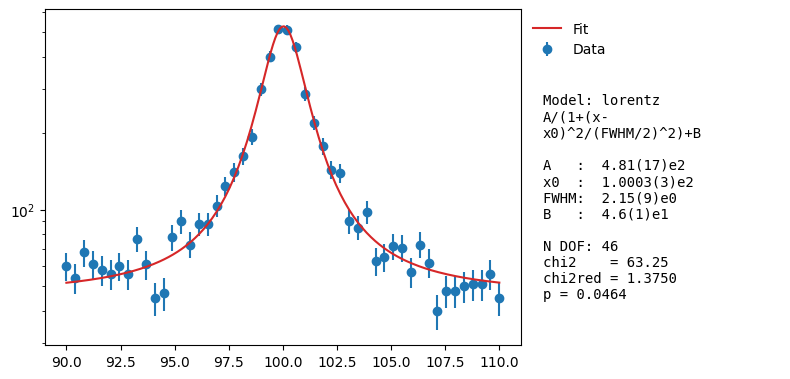

In [16]:
fig = fit.plot(logy=True)

Logarithmic x-axis can be envoked with logx=True

### Show guess

Here, guess refers to the guess parameter values used to initiate the fitting.

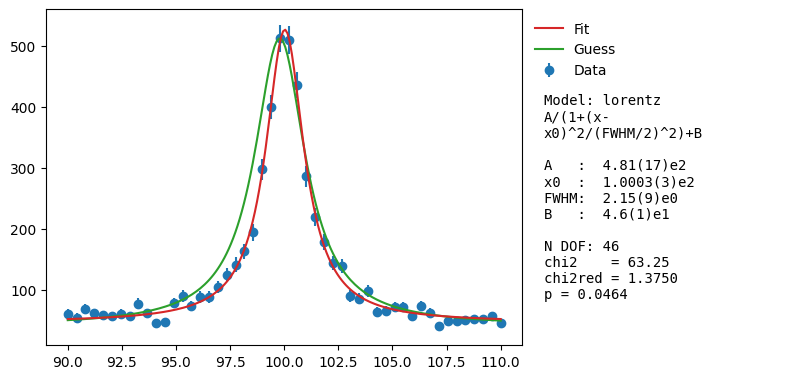

In [17]:
fit.plot(plot_guess = True);

You can also plot the guess alone in case the fit has failed

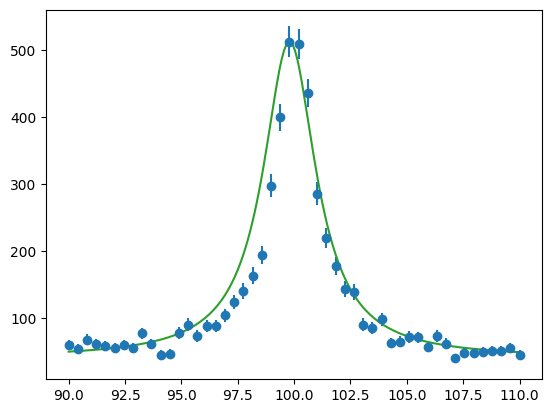

In [18]:
fig = fit.plot_guess();

### Plot residuals

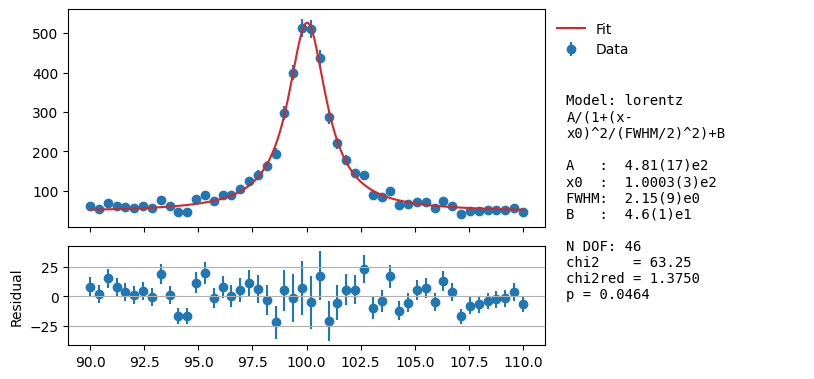

In [19]:
fit.plot(plot_residuals=True);

### Add axes labels

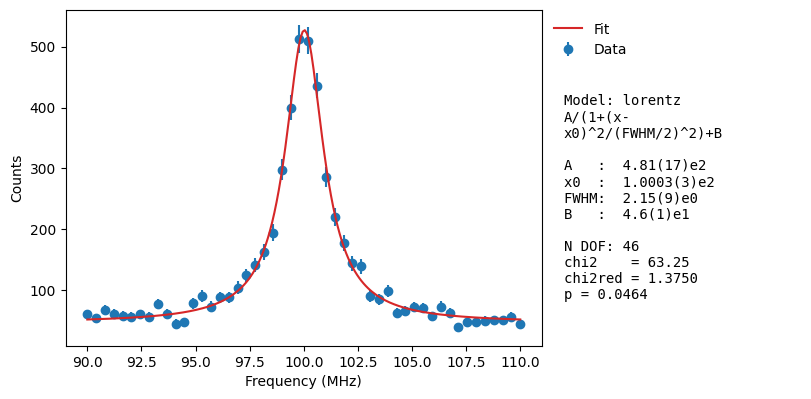

In [20]:
fit.plot(xlabel='Frequency (MHz)', ylabel='Counts');

### Additional keyword arguments

'N' : Number of points in the fit and guess curves. Increase to make fit curve look smoother. Default is 200.

'figsize' : Tupple used to set figure size

'fmt' : Marker format used for data plotting. Default is 'o'

'print params' : Toggles text output on the right of the figure. Default is True.    

# More fitting functionality

### Fixing parameters

You may wish to fix one or more parameters to a known value. To do this you can pass dictionary with the name of the fit parameters and their value. For example, lets fix the backgroud of the example lorentzian to 0.

In [21]:
fit = lazyfit.fit('lorentz', x, y, dy, fix={'B':0})

You will see that the fit has changed as that the list of fit parameters indicates that B is fixed to 0.

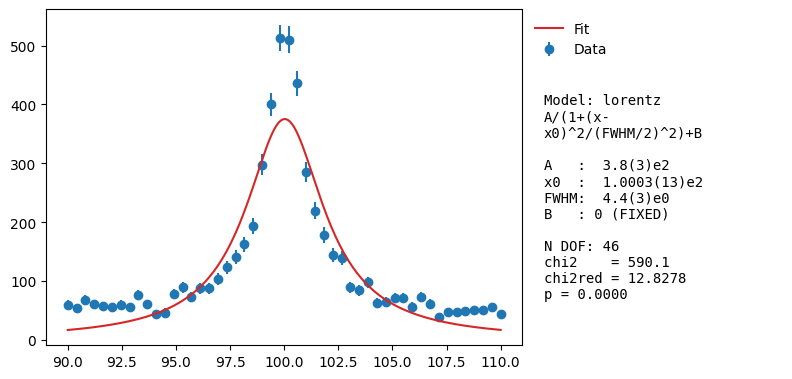

In [22]:
fit.plot();

### Manual parameter limits and guesses

By default, lazyfit generates its own guess and limits for the fit parameters to facilitate a successful fit. These can be overwritten at any time with keyword arguments

Manually specify the guess by providing a list:

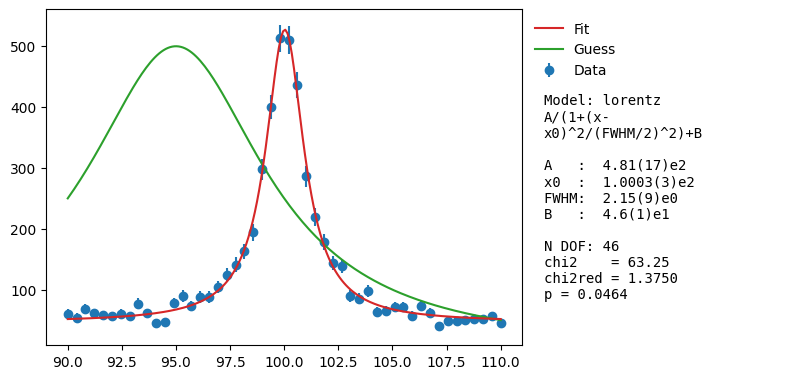

In [23]:
fit = lazyfit.fit('lorentz', x, y, dy, guess = [500, 95, 10,0]) # provide manual guess
fit.plot(plot_guess=True);

Manual bounds requires a tupple of lower bound and upper bound lists.
Beware, the scipy fitting may produce errors if bounds are too restrictive

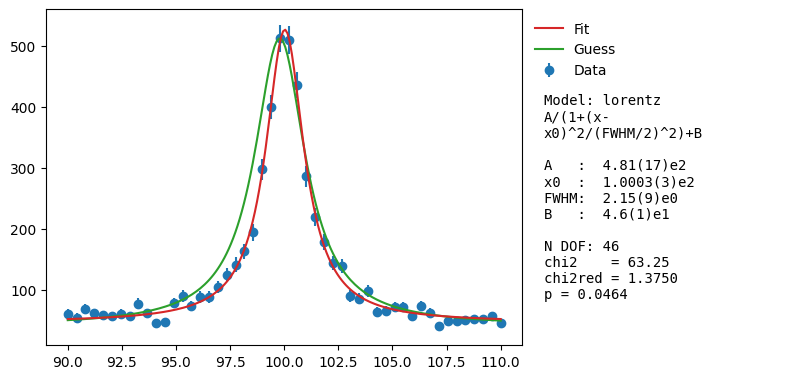

In [24]:
lb = [0,0,0,0] # lower bounds
ub = [600,200,10,200] # upper bounds
fit = lazyfit.fit('lorentz', x, y, dy, bounds=(lb, ub)) # provide manual guess
fit.plot(plot_guess=True);

### Passing on scipy fit options

You can pass a dictionary of keyword arguments to the scipy.curve_fit() routine using the 'options' keyword of lazyfit.fit(). This is helpfull eg. if you need to increase the max number of itterations

In [25]:
fit = lazyfit.fit('lorentz', x, y, dy, options={'maxfev':10000})

# Other statistical information

In [26]:
fit.get_chi2() # get chi squared value

63.24996488292252

In [27]:
fit.get_pval() # get the p-value of the pearson chi2 test

0.04643703066043608

In [28]:
fit.n_DOF # numer of degrees of freedom

46

# Debugging tips

By calling lazyfit.fit(), the fitting routine is automatically called. If you wish to inspect the data and parameter guess before fitting you can create the wrapper object using the same keyword arguments as lazyfit.fit(). The fitting can be performed by calling the .fit() method.

In [29]:
wrapper = lazyfit.Wrapper('lorentz', x, y, dy) # same arguments and keywords

In [30]:
wrapper

In [31]:
wrapper.guess # inspect the fit parameter guess

[473, 99.79591836734694, 2.857142857142861, 40]

In [32]:
wrapper.fit() # invoke the fitting

# Adding your own fit models

Fitmodels are defined as objects of the lazyfit.models.LazyFitModel class. Here is an example on how to define a new model from scratch for fitting the function f(x) = A*sqrt(x)+B:

In [33]:
def func_sqrt(x, A, B): 
    '''the fit model which is evaluated. x is always first argument followed by bit parameters'''
    return A * np.sqrt(x) + B

def guess_sqrt(x, y):
    '''function for getting a guess on fit parameters'''
    B = np.min(y)
    A = (np.max(y)-B)/np.sqrt(np.max(x))
    return [A,B]

def bounds_sqrt(x, y):
    '''function for setting parameter bounds'''
    lb = [-np.inf, -np.inf]
    ub = [np.inf, np.inf]
    return lb, ub

# pass a name (as string), model function, guess, and bounds, and math expression to the function.
model_sqrt = lazyfit.models.LazyFitModel('My sqrt', func_sqrt, guess_sqrt, bounds_sqrt, 'A*sqrt(x)+B') 

Note that guess, bounds, and the math expression are optional!

In [34]:
# generate test data
x2 = np.linspace(0,10,50)
y2 = 2*np.sqrt(x2) + 1 + np.random.normal(scale=0.2, size=x2.size)

In [35]:
fit = lazyfit.fit(model_sqrt, x2, y2, dy=0.2)

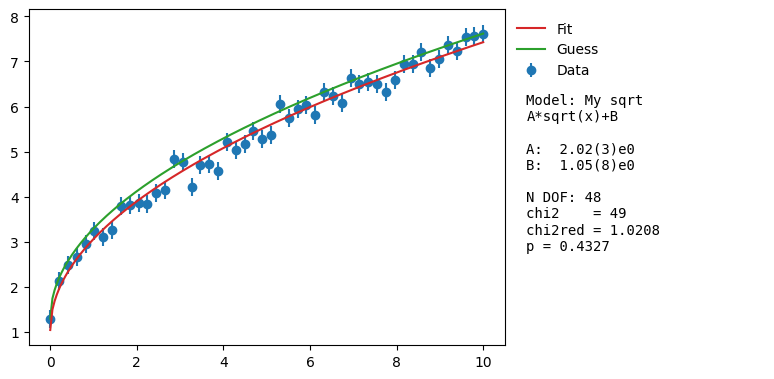

In [36]:
fit.plot(plot_guess=True);

Also note that printing the fitmodel displays the model name and fit parameters

In [37]:
model_sqrt

<LazyFitModel "My sqrt". Fit parameters: ['A', 'B']>